In [1]:
import pandas as pd
import numpy as np
import re
import string
import spacy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [2]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.1/12.8 MB 1.7 MB/s eta 0:00:08
      --------------------------------------- 0.2/12.8 MB 2.0 MB/s eta 0:00:07
      --------------------------------------- 0.2/12.8 MB 1.5 MB/s eta 0:00:09
      --------------------------------------- 0.3/12.8 MB 1.7 MB/s eta 0:00:08
     - -------------------------------------- 0.4/12.8 MB 1.9 MB/s eta 0:00:07
     - -------------------------------------- 0.5/12.8 MB 1.9 MB/s eta 0:00:07
     - -------------------------------------- 0.5/12.8 MB 1.6 MB/s eta 0:00:08
     -- ------------------------------------- 0.7/12.8 MB 1.8 MB/s eta 0:00:07
     -- ------------------------------------- 0.7/12.8 MB 1.8 MB/s eta 0:00:07
     -- ------------------------------------- 0.8/12.8 MB 1.7 MB/s eta 0:00:08
     -- ------------------------------------- 0.9/12.8 MB 1.9 MB/s eta 0:00:07
     --- ------------------------------------ 1.1/12.8 MB 2

# Получение данных
[
Spam or Not Spam Dataset](https://www.kaggle.com/datasets/ozlerhakan/spam-or-not-spam-dataset/)

In [3]:
data = pd.read_csv('spam_or_not_spam.csv')
data = data.astype({'email':'string'})
data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [4]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2999 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   2999 non-null   string
 1   label   2999 non-null   int64 
dtypes: int64(1), string(1)
memory usage: 70.3 KB


In [5]:
data['label'].value_counts()

label
0    2500
1     499
Name: count, dtype: int64

# Очистка

Стоп-слова для английского языка в spaCy

In [6]:
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words
print(f'Spacy english stopwords size: {len(stopwords)}', end='\n\n')
' '.join(stopwords)

Spacy english stopwords size: 326



"themselves this hereby whereby toward more ever forty there anywhere wherein might several below without been had another upon thereby by ours keep ‘ll rather five various one amount nobody ’d eight of next made still can such which first behind ourselves take no anyone has also hundred cannot else thru were ’ll per off often many well but being afterwards in alone mine himself you twenty her am anything whereas everywhere us doing along was except thereupon we through hers side too anyway could itself 'd put hence done your nothing always nowhere wherever very somewhere fifteen into elsewhere as latterly just whole whether otherwise even part ’re only all full does nevertheless somehow anyhow seems among his using go between fifty because thereafter them every ten until around its beyond really is back seemed whoever here call although indeed herein name used during less perhaps thus whereupon beforehand hereafter herself if throughout almost something whereafter 'm and ’s whatever b

Атрибуты [Token](https://spacy.io/api/token#attributes)

In [7]:
%%time

data['cleaned_text'] = data['email'].apply(
    lambda x: ' '.join(
        token.lemma_.lower() for token in nlp(x) if
        not token.is_stop
        and not token.is_punct
        and not token.is_digit
        and not token.like_email
        and not token.like_num
        and not token.is_space
    )
)
data.head()

CPU times: total: 2min 3s
Wall time: 2min 3s


,email,label,cleaned_text
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0,date d number aug number number number number ...
1,martin a posted tassos papadopoulos the greek ...,0,martin post tassos papadopoulo greek sculptor ...
2,man threatens explosion in moscow thursday aug...,0,man threaten explosion moscow thursday august ...
3,klez the virus that won t die already the most...,0,klez virus win t die prolific virus klez conti...
4,in adding cream to spaghetti carbonara which ...,0,add cream spaghetti carbonara effect pasta mak...


# Векторизация и классификация

## CountVectorizer

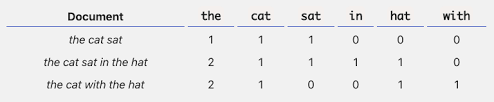

- приводит к нижнему регистру
- проводит токенизацию - `r"(?u)\b\w\w+\b"` (токены из 2 или более буквенно-цифровых символов, пунктуация полностью игнорируется и всегда рассматривается как разделитель токенов)
  - `(?u)` - флаг Unicode
  - `\b` - граница слова
  - `\w` - символы, которые могут входить в состав слов, включая числа и подчёркивание
  - `\+` - 1 и более повторений предшествующего выражения
- фильтрует стоп-слова

### Train/test split & fit

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['label'], random_state=2023)

In [9]:
vectorizer = CountVectorizer(max_df=0.7, min_df=0.003) # max_df фильтрует corpus-specific stop words
X_train_vectorized = vectorizer.fit_transform(X_train) 
X_test_vectorized = vectorizer.transform(X_test)

### Бейзлайн - константное предсказание

In [10]:
dummy_clf = DummyClassifier(strategy="most_frequent").fit(X_train_vectorized, y_train)
preds = dummy_clf.predict(X_test_vectorized)
print(classification_report(y_test, preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       616
           1       0.00      0.00      0.00       134

    accuracy                           0.82       750
   macro avg       0.41      0.50      0.45       750
weighted avg       0.67      0.82      0.74       750



### Логистическая регрессия

In [11]:
logreg = LogisticRegression().fit(X_train_vectorized, y_train)
preds_count_vec = logreg.predict(X_test_vectorized)
print(classification_report(y_test, preds_count_vec))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       616
           1       0.98      0.93      0.95       134

    accuracy                           0.98       750
   macro avg       0.98      0.96      0.97       750
weighted avg       0.98      0.98      0.98       750



### Переопределение токенизатора, препроцессинга

In [12]:
def custom_tokenize(text):
  text = re.sub(r'[^a-zA-Z ]', '', text)
  return text.split()

In [13]:
custom_vectorizer = CountVectorizer(
    max_df=0.7,
    min_df=0.003,
    tokenizer=custom_tokenize, # аналогично можно переопределить preprocessor
    token_pattern=None
)
X_train_vectorized = custom_vectorizer.fit_transform(X_train)
X_test_vectorized = custom_vectorizer.transform(X_test)

In [14]:
logreg = LogisticRegression().fit(X_train_vectorized, y_train)
preds = logreg.predict(X_test_vectorized)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       616
           1       0.95      0.93      0.94       134

    accuracy                           0.98       750
   macro avg       0.97      0.96      0.96       750
weighted avg       0.98      0.98      0.98       750



Стало работать хуже с новым токенизатором.

## Tf-Idf

В объемном корпусе некоторые слова будут присутствовать в большом количестве документов (текстов), а значит, они несут очень мало значимой информации о фактическом содержании документа.

Для решения этой проблемы можно использовать Tf-Idf подход

Цель использования tf-idf состоит в том, чтобы уменьшить влияние токенов, которые очень часто встречаются в данном корпусе и, следовательно, эмпирически менее информативны, чем признаки, которые встречаются малой части корпуса



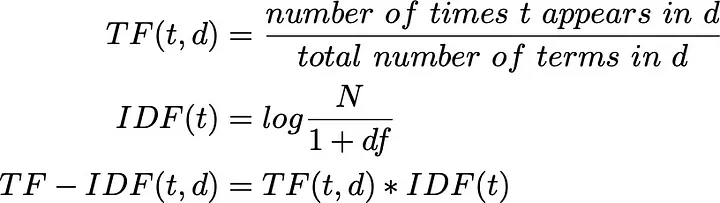

Отличия в реализации Sklearn

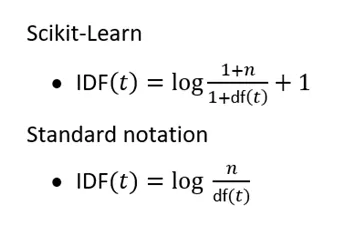

Также в Scikit-Learn результирующие векторы TF-IDF нормализуются по евклидовой норме, что облегчает расчет cosine similarity:
`The cosine similarity between two vectors is their dot product when l2 norm has been applied`

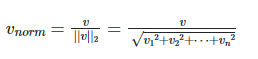

In [15]:
pipe = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression())
    ]
).fit(X_train, y_train)
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       616
           1       1.00      0.77      0.87       134

    accuracy                           0.96       750
   macro avg       0.98      0.88      0.92       750
weighted avg       0.96      0.96      0.96       750



Сравним с CountVectorizer:

In [16]:
print(classification_report(y_test, preds_count_vec))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       616
           1       0.98      0.93      0.95       134

    accuracy                           0.98       750
   macro avg       0.98      0.96      0.97       750
weighted avg       0.98      0.98      0.98       750



Для разных задач нужно оптимизировать разные метрики, так что оба решения имеют место быть, к тому же, их еще можно запускать на разных параметрах.

# Оптимизация гиперпараметров пайплайна целиком - HalvingGridSearchCV

## Логистическая регрессия

In [17]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression())
    ]
)

In [18]:
parameter_grid = {
    "counter__max_df": np.linspace(0.3, 0.7, 10),
    "counter__min_df": [0.0, 0.001, 0.003, 0.005],
    "counter__ngram_range": ((1, 1), (1, 2)),  # слова или биграммы
    "tfidf__norm": ("l1", "l2"),
    "clf__C": np.linspace(0.1, 1, 10),
}

In [19]:
%%time

grid_search = HalvingGridSearchCV(
    pipe,
    param_grid=parameter_grid,
    n_jobs=-1,
    cv=5,
    scoring='accuracy',
    random_state=42,
)
grid_search.fit(X_train, y_train)

CPU times: total: 1min 53s
Wall time: 3min 22s


HalvingGridSearchCV(estimator=Pipeline(steps=[('counter', CountVectorizer()),
                                              ('tfidf', TfidfTransformer()),
                                              ('clf', LogisticRegression())]),
                    n_jobs=-1,
                    param_grid={'clf__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                'counter__max_df': array([0.3       , 0.34444444, 0.38888889, 0.43333333, 0.47777778,
       0.52222222, 0.56666667, 0.61111111, 0.65555556, 0.7       ]),
                                'counter__min_df': [0.0, 0.001, 0.003, 0.005],
                                'counter__ngram_range': ((1, 1), (1, 2)),
                                'tfidf__norm': ('l1', 'l2')},
                    random_state=42, scoring='accuracy')

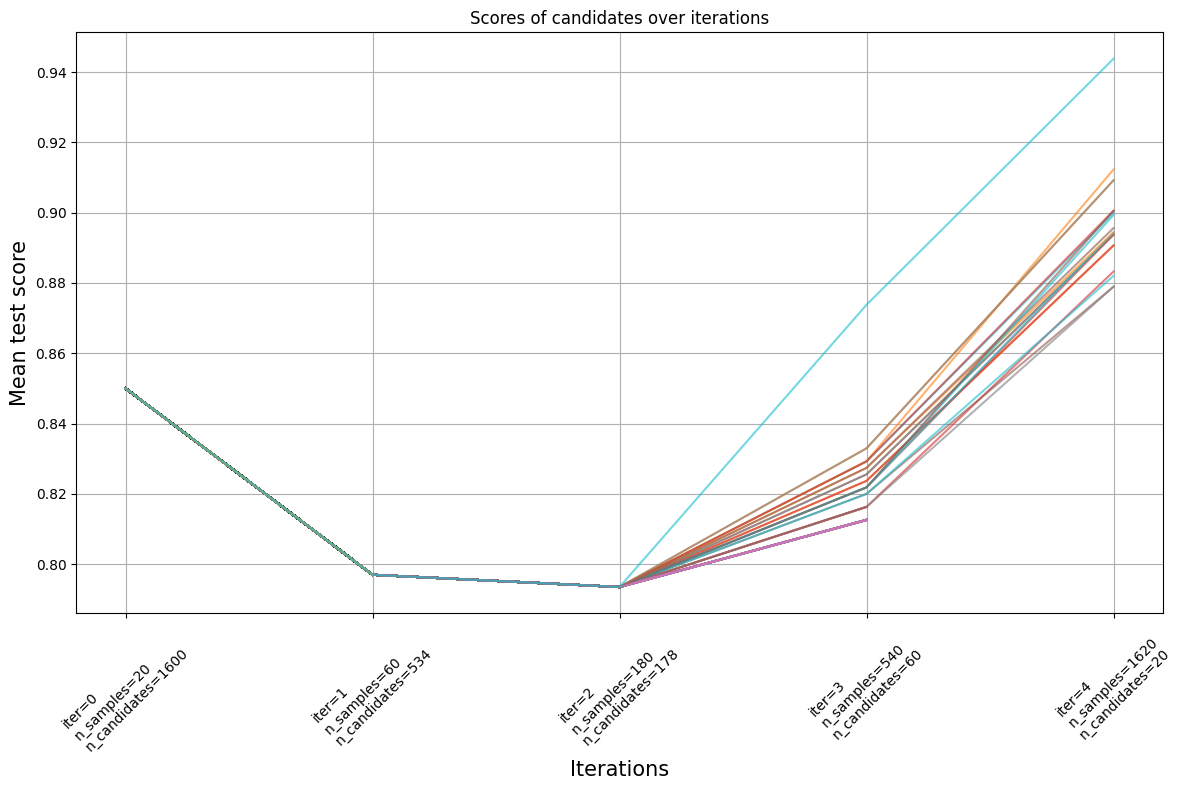

best_score: 0.9437927607690251


In [20]:
def plot(grid_search):
    plt.rcParams["figure.figsize"] = (12, 8)
    results = pd.DataFrame(grid_search.cv_results_)
    results["params_str"] = results.params.apply(str)
    results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
    mean_scores = results.pivot(
        index="iter",
        columns="params_str",
        values="mean_test_score",
    )
    ax = mean_scores.plot(legend=False, alpha=0.6)

    labels = [
        f"iter={i}\nn_samples={grid_search.n_resources_[i]}\nn_candidates={grid_search.n_candidates_[i]}"
        for i in range(grid_search.n_iterations_)
    ]

    ax.set_xticks(range(grid_search.n_iterations_))
    ax.set_xticklabels(labels, rotation=45, multialignment="left")
    ax.set_title("Scores of candidates over iterations")
    ax.set_ylabel("Mean test score", fontsize=15)
    ax.set_xlabel("Iterations", fontsize=15)
    plt.tight_layout()
    plt.grid()
    plt.show()

plot(grid_search)
print("best_score:", grid_search.best_score_)

In [21]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       616
           1       1.00      0.85      0.92       134

    accuracy                           0.97       750
   macro avg       0.98      0.93      0.95       750
weighted avg       0.97      0.97      0.97       750



In [22]:
## Дерево решений

In [23]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', DecisionTreeClassifier())
    ]
)

parameter_grid = {
    "counter__max_df": np.linspace(0.3, 0.7, 10),
    "counter__min_df": [0.0, 0.001, 0.003, 0.005],
    "counter__ngram_range": ((1, 1), (1, 2)),  # слова или биграммы
    "tfidf__norm": ("l1", "l2")
}


In [24]:
%%time

grid_search = HalvingGridSearchCV(
    pipe,
    param_grid=parameter_grid,
    n_jobs=-1,
    cv=5,
    scoring='accuracy',
    random_state=42,
)
grid_search.fit(X_train, y_train)

CPU times: total: 13.4 s
Wall time: 32.8 s


HalvingGridSearchCV(estimator=Pipeline(steps=[('counter', CountVectorizer()),
                                              ('tfidf', TfidfTransformer()),
                                              ('clf',
                                               DecisionTreeClassifier())]),
                    n_jobs=-1,
                    param_grid={'counter__max_df': array([0.3       , 0.34444444, 0.38888889, 0.43333333, 0.47777778,
       0.52222222, 0.56666667, 0.61111111, 0.65555556, 0.7       ]),
                                'counter__min_df': [0.0, 0.001, 0.003, 0.005],
                                'counter__ngram_range': ((1, 1), (1, 2)),
                                'tfidf__norm': ('l1', 'l2')},
                    random_state=42, scoring='accuracy')

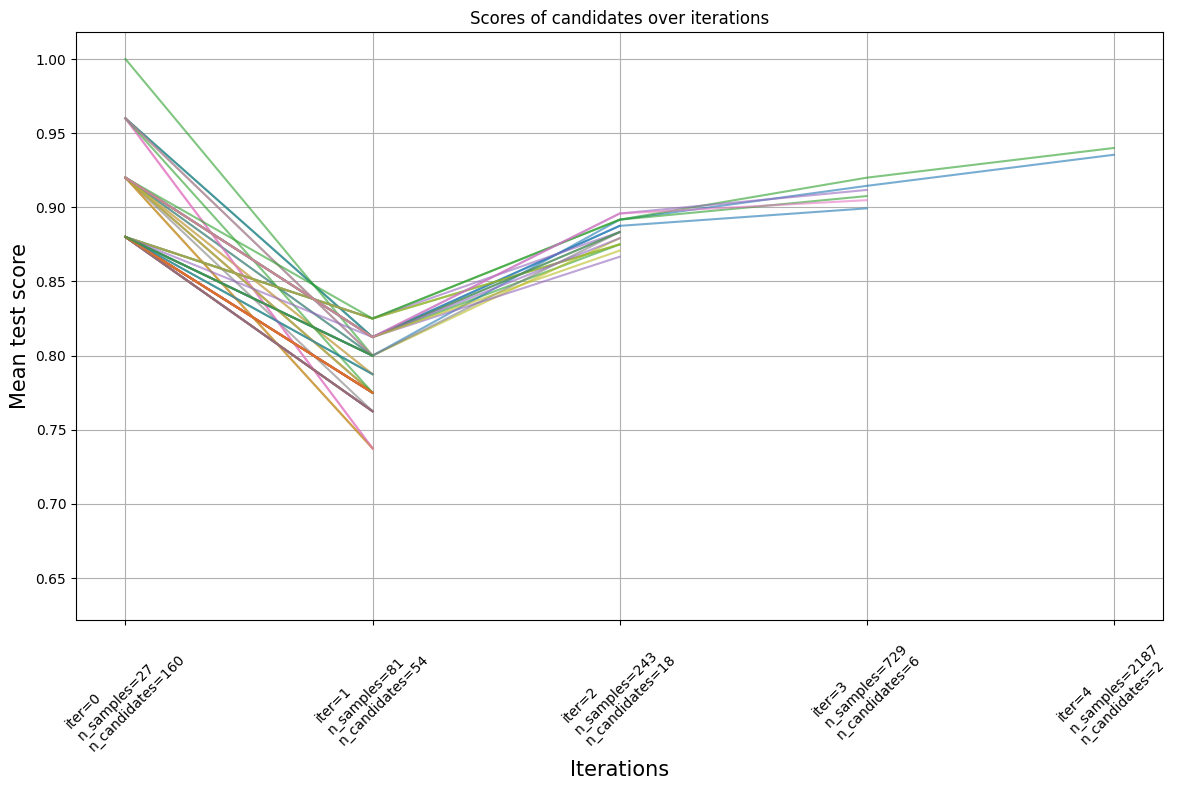

best_score: 0.9400174248945058


In [25]:
plot(grid_search)
print("best_score:", grid_search.best_score_)

In [26]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       616
           1       0.83      0.91      0.87       134

    accuracy                           0.95       750
   macro avg       0.91      0.93      0.92       750
weighted avg       0.95      0.95      0.95       750



## Наивный Байесовский классификатор

In [27]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB())
    ]
)

parameter_grid = {
    "counter__max_df": np.linspace(0.3, 0.7, 10),
    "counter__min_df": [0.0, 0.001, 0.003, 0.005],
    "counter__ngram_range": ((1, 1), (1, 2)),  # слова или биграммы
    "tfidf__norm": ("l1", "l2"),
}


In [28]:
%%time

grid_search = HalvingGridSearchCV(
    pipe,
    param_grid=parameter_grid,
    n_jobs=-1,
    cv=5,
    scoring='accuracy',
    random_state=42,
)
grid_search.fit(X_train, y_train)

CPU times: total: 10.7 s
Wall time: 21.2 s


HalvingGridSearchCV(estimator=Pipeline(steps=[('counter', CountVectorizer()),
                                              ('tfidf', TfidfTransformer()),
                                              ('clf', MultinomialNB())]),
                    n_jobs=-1,
                    param_grid={'counter__max_df': array([0.3       , 0.34444444, 0.38888889, 0.43333333, 0.47777778,
       0.52222222, 0.56666667, 0.61111111, 0.65555556, 0.7       ]),
                                'counter__min_df': [0.0, 0.001, 0.003, 0.005],
                                'counter__ngram_range': ((1, 1), (1, 2)),
                                'tfidf__norm': ('l1', 'l2')},
                    random_state=42, scoring='accuracy')

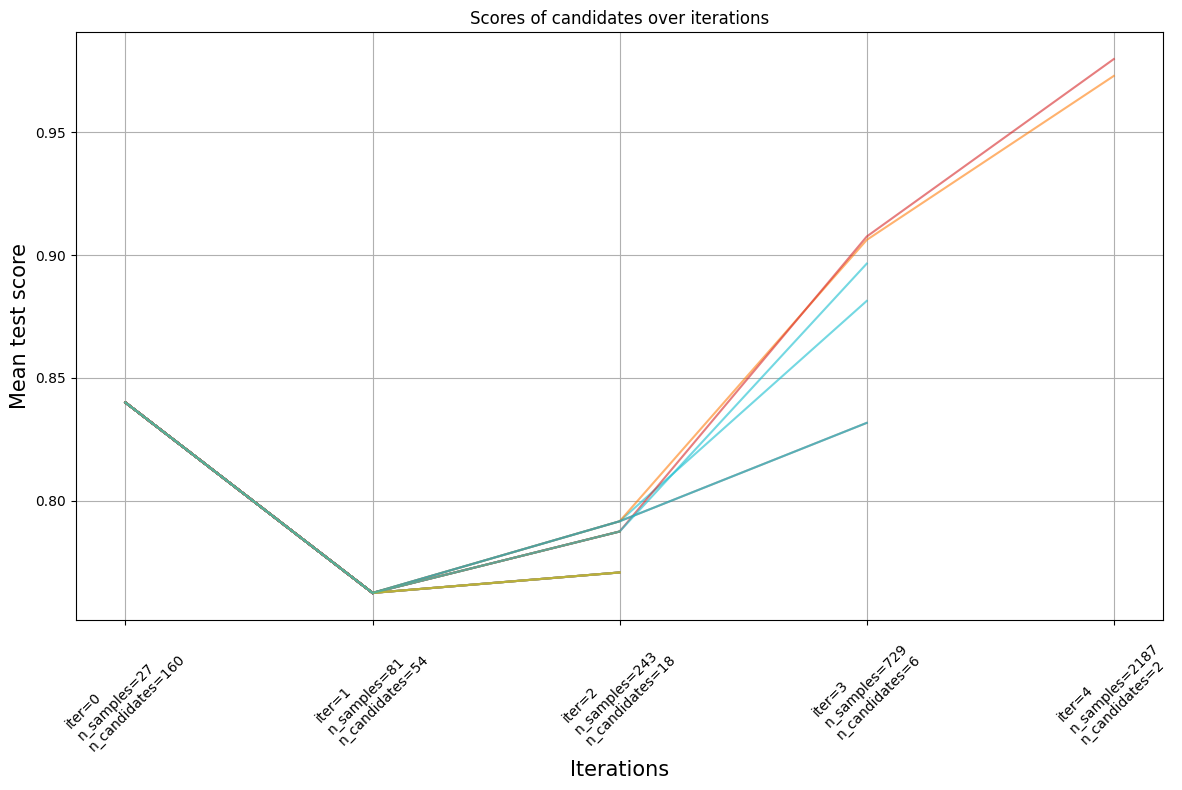

best_score: 0.9798459051497911


In [29]:
plot(grid_search)
print("best_score:", grid_search.best_score_)

In [30]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       616
           1       0.97      0.93      0.95       134

    accuracy                           0.98       750
   macro avg       0.98      0.96      0.97       750
weighted avg       0.98      0.98      0.98       750



На тестовых данных accuracy лучше всего у Байесовского классификатора - 0.98, потом у логистической регресссии - 0.97, потом дерево решений - 0.95.